In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import pairplot
from dsn.util.dsn_util import get_system_from_template, grid_search, abc_sample
from dsn.util.dsn_util import get_grid_search_bounds

from scipy.stats import multivariate_normal as mvn
import scipy
import time
import warnings
warnings.filterwarnings("ignore")
import os

os.chdir('../../')

In [2]:
sysname = 'LowRankRNN'
rank = 1
input_type = 'input'
behavior_type = 'BI'
param_dict = {'rank':rank,
              'input_type':input_type,
              'behavior_type':behavior_type,
              'solve_its':10,
              'gauss_newton':False,
              'variance':0.01,
              'solve_eps':0.2}
system = get_system_from_template(sysname, param_dict)
print('free params')
print(system.free_params)
print('fixed params')
print(system.fixed_params)
print('mu')
print(system.mu)

free params
['g', 'Mm', 'Mn']
fixed params
{'MI': 2.0, 'Sm': 1.0, 'Sn': 1.0, 'SmI': 0.0, 'SnI': 1.0, 'Sperp': 0.0}
mu
[3.   0.5  0.01 0.01]


In [3]:
Z = tf.placeholder(tf.float64, (1,None,system.D))
T_x = system.compute_suff_stats(Z)
n_rs = 1000
Z_a, Z_b, _, _ = get_grid_search_bounds(system)
Z_rs = np.zeros((n_rs, system.D))
for i in range(system.D):
    Z_rs[:,i] = np.random.uniform(Z_a[i], Z_b[i], (n_rs,))
    
with tf.Session() as sess:
    _T_x = sess.run(T_x, {Z:np.expand_dims(Z_rs, 0)})

data/warm_starts/rank1_BI_a=0.00E+00_-5.00E+00_-5.00E+00_b=5.00E+00_5.00E+00_5.00E+00_step=5.00E-01.npz
nvals [11, 21, 21, 1, 1, 1, 1, 1, 1]
m 4851
i 0 0.2002 seconds
i 100 0.1997 seconds
i 200 0.2047 seconds
i 300 0.2059 seconds
i 400 0.1966 seconds
i 500 0.2028 seconds
i 600 0.2233 seconds
i 700 0.2236 seconds
i 800 0.2461 seconds
i 900 0.2515 seconds
i 1000 0.2645 seconds
i 1100 0.2646 seconds
i 1200 0.2553 seconds
i 1300 0.2534 seconds
i 1400 0.2543 seconds


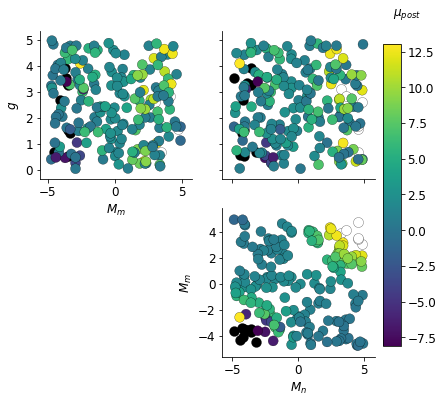

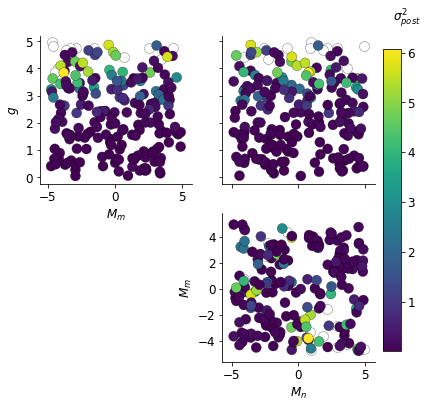

In [4]:
n_plot = 200
fig = pairplot(Z_rs[:n_plot,:], range(3), system.z_labels, 
               c=_T_x[0,:n_plot,0], c_label=r'$\mu_{post}$',
               figsize=(6,6))
fig = pairplot(Z_rs[:n_plot,:], range(3), system.z_labels, 
               c_label=r'$\sigma_{post}^2$',
               c=_T_x[0,:n_plot,1], figsize=(6,6))

In [10]:
"""n_abc = 100000
inds =  [0,1]
Z_abc = abc_sample(system, n_abc, sigma=0.1, inds=inds)
n_accepted = Z_abc.shape[0]
print('%d accepted, %.4f %%' % (n_accepted, 100* (n_accepted/n_abc)))
with tf.Session() as sess:
    _T_x_abc = sess.run(T_x, {Z:np.expand_dims(Z_abc, 0)})

d = np.sqrt(np.sum(np.square(_T_x_abc[0,:,inds].T - np.expand_dims(system.mu[inds], 0)), axis=1))

a, b = system.density_network_bounds

fig = pairplot(Z_abc[:n_plot,:], range(3), system.z_labels, 
               c=d[:n_plot], figsize=(6,6))"""

data/warm_starts/rank1_BI_a=0.00E+00_-5.00E+00_-5.00E+00_b=5.00E+00_5.00E+00_5.00E+00_step=5.00E-01.npz
Already warm_started.
data/warm_starts/rank1_BI_a=0.00E+00_-5.00E+00_-5.00E+00_b=5.00E+00_5.00E+00_5.00E+00_step=5.00E-01.npz
18 accepted, 0.0180 %


In [5]:
from dsn.util.tf_DMFT_solvers import warm_start
ws_filename, _ = warm_start(system)
ws_file = np.load(ws_filename)
param_grid = ws_file['param_grid']
solution_grid = ws_file['solution_grid']
print(param_grid.shape, solution_grid.shape)

data/warm_starts/rank1_BI_a=0.00E+00_-5.00E+00_-5.00E+00_b=5.00E+00_5.00E+00_5.00E+00_step=5.00E-01.npz
Already warm_started.
data/warm_starts/rank1_BI_a=0.00E+00_-5.00E+00_-5.00E+00_b=5.00E+00_5.00E+00_5.00E+00_step=5.00E-01.npz
(3, 4851) (4851, 4)


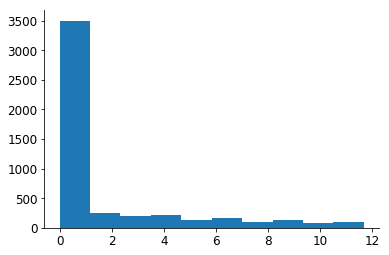

In [6]:
mu = solution_grid[:,0]
kappa = solution_grid[:,1]
delta0 = solution_grid[:,2]
deltainf = solution_grid[:,3]
deltaT = delta0-deltainf
plt.figure()
plt.hist(deltaT)
plt.show()

In [7]:
xs = system.xs
with tf.Session() as sess:
    _xs = sess.run(xs, {Z:np.expand_dims(Z_rs, 0)})

[[0.12938577 0.12926691 0.12915664 ... 0.12861177 0.12852712 0.12844236]
 [0.01413992 0.01413082 0.01412179 ... 0.01405346 0.01404118 0.01403063]
 [0.69280399 0.69274671 0.69270274 ... 0.69232144 0.69222153 0.69211558]
 ...
 [0.50070406 0.5005048  0.50023099 ... 0.49785494 0.49740251 0.49694263]
 [0.0183237  0.01830951 0.01829519 ... 0.01820795 0.01819333 0.01817871]
 [0.06261909 0.06258812 0.062558   ... 0.06238393 0.06235509 0.0623262 ]]


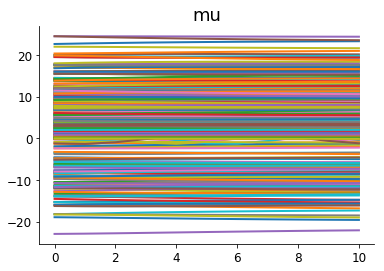

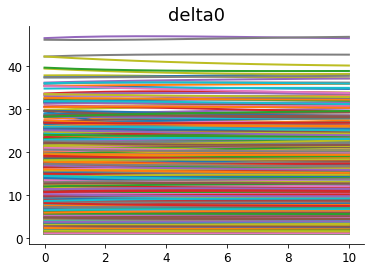

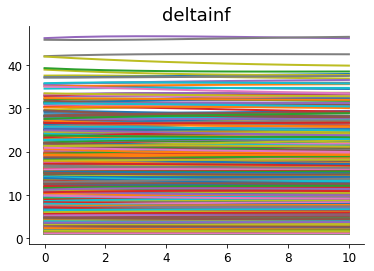

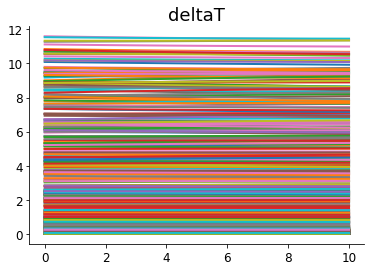

In [8]:
mu = _xs[:,0,:]
square_diff = _xs[:,2,:]
delta_inf = _xs[:,3,:]
delta_0 = np.sqrt(2*square_diff + np.square(delta_inf))
delta_T = delta_0 - delta_inf
print(delta_T)
num_plot = _xs.shape[0]
plt.figure()
plt.plot(mu[:num_plot,:].T)
plt.title('mu')
plt.show()
plt.figure()
plt.plot(delta_0[:num_plot,:].T)
plt.title('delta0')
plt.show()
plt.figure()
plt.plot(delta_inf[:num_plot,:].T)
plt.title('deltainf')
plt.show()
plt.figure()
plt.plot(delta_T[:num_plot,:].T)
plt.title('deltaT')
plt.show()

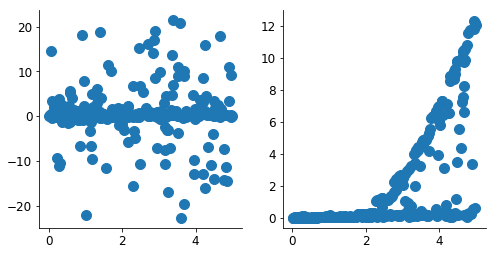

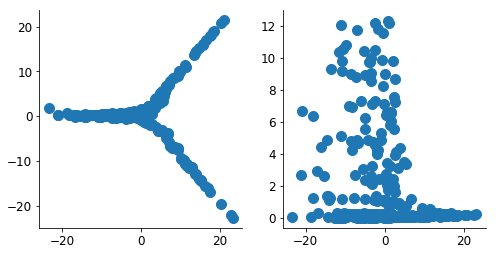

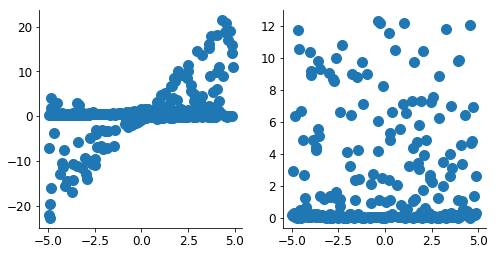

In [8]:

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].scatter(g, _T_x[0,:,0])
axs[1].scatter(g, _T_x[0,:,1])
plt.show()

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].scatter(Mm*Mn, _T_x[0,:,0])
axs[1].scatter(Mm*Mn, _T_x[0,:,1])
plt.show()

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].scatter(Mn, _T_x[0,:,0])
axs[1].scatter(Mn, _T_x[0,:,1])
plt.show()

(2, 2001)


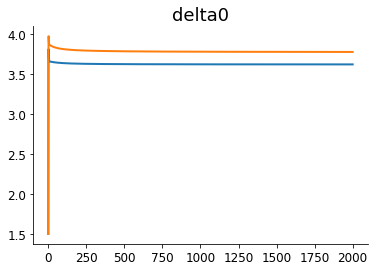

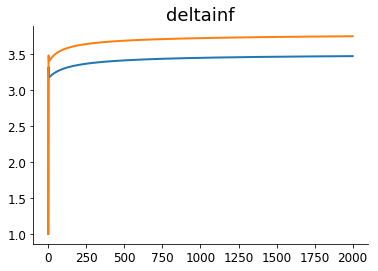

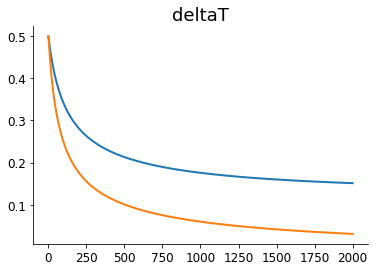

In [15]:
square_diff = _xs[:,2,:]
delta_inf = _xs[:,3,:]
delta_0 = np.sqrt(2*square_diff + np.square(delta_inf))
delta_T = delta_0 - delta_inf
print(delta_T.shape)
num_plot = 30
plt.figure()
plt.plot(delta_0[:num_plot,:].T)
plt.title('delta0')
plt.show()
plt.figure()
plt.plot(delta_inf[:num_plot,:].T)
plt.title('deltainf')
plt.show()
plt.figure()
plt.plot(delta_T[:num_plot,:].T)
plt.title('deltaT')
plt.show()

(1, 2, 2)


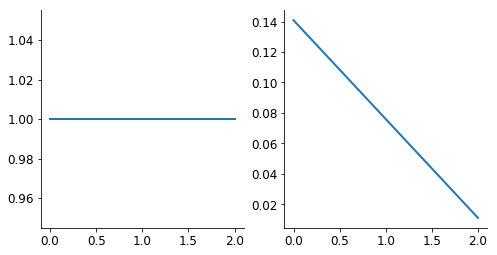

In [16]:
_MI = np.ones((M,))
_SnI =  np.linspace(0, 2.0, M)
_Z = np.expand_dims(np.stack((_MI, _SnI), axis=1), 0)
print(_Z.shape)
with tf.Session() as sess:
    _T_x, _xs = sess.run([T_x, xs], {Z:_Z})
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].plot(_SnI, _T_x[0,:,0])
axs[1].plot(_SnI, _T_x[0,:,1])
plt.show()

(2, 2001)


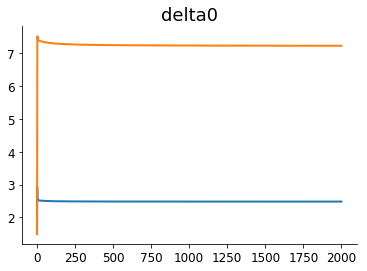

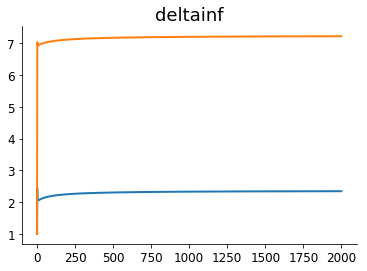

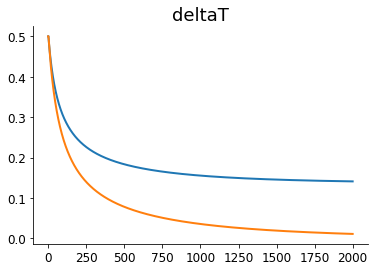

In [17]:
square_diff = _xs[:,2,:]
delta_inf = _xs[:,3,:]
delta_0 = np.sqrt(2*square_diff + np.square(delta_inf))
delta_T = delta_0 - delta_inf
print(delta_T.shape)
num_plot = 30
plt.figure()
plt.plot(delta_0[:num_plot,:].T)
plt.title('delta0')
plt.show()
plt.figure()
plt.plot(delta_inf[:num_plot,:].T)
plt.title('deltainf')
plt.show()
plt.figure()
plt.plot(delta_T[:num_plot,:].T)
plt.title('deltaT')
plt.show()